In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


## Importing The Required Libraries 

In [2]:
!pip install torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install torchtext==0.18.0 --no-deps
  

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 7.7 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 91.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 115.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 35.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [3]:
import torchtext
torchtext.__version__

'0.18.0+cpu'

In [4]:
import torch 
import torchtext 
from torchtext import vocab
from torchtext.vocab import GloVe
import pandas as pd
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence 

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## Loading The Data

In [5]:
 data=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
data["sentiment"] = data["sentiment"].map({
    "negative": 0,
    "positive": 1
})


In [7]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [8]:
class CSVDataset(Dataset):
    def __init__(self,dataframe):
        self.df=dataframe.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        review=self.df.iloc[idx]['review']
        label=torch.tensor(self.df.iloc[idx]['sentiment'],dtype=torch.long)
        return review,label

In [9]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(data,test_size=0.2,random_state=42)
train_dataset=CSVDataset(train_df)
test_dataset=CSVDataset(test_df)

## DataLoader

In [10]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True)

In [11]:
reviews,labels=next(iter(train_dataloader))
print(reviews[0],labels[0])

Wow - most of the audience just seemed to shake their heads through much of this documentary at the sheer wizardry displayed on screen.<br /><br />The shift from the early days as a New-York based black-American phenomenon to current days as a racially diverse subculture (and largely West Coast-based) is profiled well.<br /><br />The humble turntable is not given the respect of any traditional musical instrument, but it can be so much more versatile and technically complex. These DJs take the required skills for any musical instrument - dexterity, rhythm and timing, among others - and apply them to a new technology with several more variables.<br /><br />DJ Qbert's comment that he pictures what "music" must sound like on advanced planets and then works it out, seemingly silly at first, makes more and more sense as you watch these guys go and spit out a multitude of sounds that no single traditional instrument could ever create!<br /><br />Some critics have said that this film focuses t

## Getting Glove Embeddings and Indexes

In [12]:
glove=GloVe(name="6B",dim=50)

.vector_cache/glove.6B.zip: 862MB [04:03, 3.54MB/s]                               
100%|█████████▉| 399999/400000 [00:10<00:00, 37345.29it/s]


In [13]:
import torch.nn as nn
embeddings=nn.Embedding.from_pretrained(glove.vectors,freeze=True)

In [14]:
from torchtext.data.utils import get_tokenizer
import nltk
tokenizer=get_tokenizer("basic_english")

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [15]:
word_to_index=glove.stoi
index_to_word=glove.itos
vocab = torchtext.vocab.vocab(glove.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [16]:
vocab_size=len(vocab)
vocab_size

400002

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In [19]:
max_len=256
def collate_batch(batch):
    label_list=[]
    text_list=[]
    for _text,_label in  batch:
        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text)[:max_len],dtype=torch.int64))
    label_list=torch.tensor(label_list,dtype=torch.int64)
    text_list=pad_sequence(text_list,batch_first=True)
    return label_list.to(device),text_list.to(device)

In [20]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)


In [21]:
label,sequence=next(iter(train_dataloader))
label,sequence

(tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([[   39,    16,    50,  ...,     0,     0,     0],
         [   21,    31,  4020,  ...,     0,     0,     0],
         [   22,    33,    49,  ...,   391,   113,    83],
         ...,
         [   43,   837, 12830,  ...,     0,     0,     0],
         [   85,    83,   119,  ...,     0,     0,     0],
         [   39,  1007,    17,  ...,     0,     0,     0]], device='cuda:0'))

## Defining Normal Architecture of the Model

In [22]:
import math
import torch.nn as nn
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [23]:
class Net(nn.Module):
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        self.emb = nn.Embedding.from_pretrained(glove.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            max_len=256
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_class=2,vocab_size=vocab_size).to(device)
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Net(
  (emb): Embedding(400000, 50)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=50, out_features=2, bias=True)
)

In [25]:
imdb_label={0:"negative",1:"positive"}

In [26]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [27]:
predict("I like sports and stuff", text_pipeline, model)

'negative'

In [28]:
from tqdm.auto import tqdm
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [29]:
def save_list_to_file(lst, filename):
    with open(filename + ".txt", "w") as f:
        for item in lst:
            f.write(f"{item}\n")


In [30]:
import os
import time 
def train_model(model, optimizer, criterion, train_dataloader, test_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1),desc="Epochs", total=epochs):
        model.train()
        
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate(test_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                print("save model epoch",epoch)
                torch.save(model.state_dict(),model_path)
                save_list_to_file(lst=acc_epoch,filename=acc_dir)
                save_list_to_file(lst=cum_loss_list,filename=loss_dir)
                
    time_end = time.time()
    print(f"Training time: {time_end - time_start}")

In [31]:
import time 
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = "/kaggle/working"
file_name = "model_IMDB dataset small2.pth"
train_model(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_dataloader, 
            test_dataloader=test_dataloader, 
            epochs=2, 
            save_dir=save_dir, 
            file_name=file_name
           )

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 868.4183428883553
0.5936
save model epoch 1
Epoch 2/2 - Loss: 836.7418220043182
Training time: 42.731942653656006


In [32]:
def plot(cost,acc_epoch):
    fig,ax1=plt.subplots()
    ax1.plot(cost,color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
    ax2=ax1.twinx()
    ax2.plot(acc_epoch,color='blue')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='y', color='blue')
    fig.tight_layout()
    plt.show()

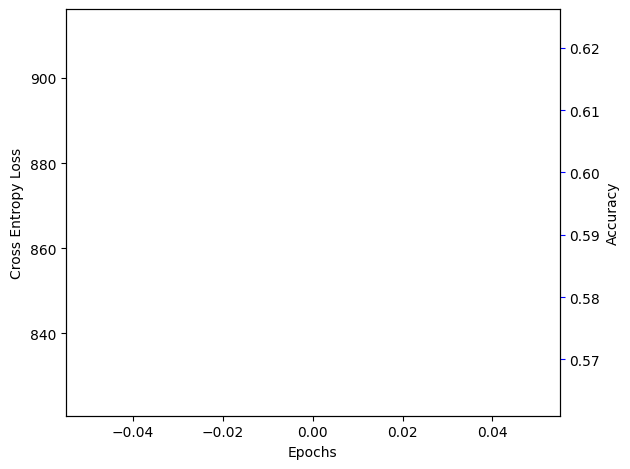

In [33]:
import matplotlib.pyplot as plt
def load_txt_to_list(filepath):
    with open(filepath, "r") as f:
        return [float(line.strip()) for line in f if line.strip()]

acc_epoch = load_txt_to_list("/kaggle/working/model_IMDB dataset small2_acc.txt")
cum_loss_list = load_txt_to_list("/kaggle/working/model_IMDB dataset small2_loss.txt")
plot(cum_loss_list,acc_epoch)

## Pretraining on AG News Dataset 



In [34]:
!pip install torchdata==0.7.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.7.1 which is incompatible.


In [35]:
ag_train=pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
ag_test=pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')

In [36]:
ag_train

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [37]:
ag_train['Class Index'].unique()

array([3, 4, 2, 1])

In [38]:
ag_map={1:"World",2:"Sports",3:"Business",4:"Science / Technology"}

In [39]:
ag_train=ag_train.drop(columns=["Title"])
ag_test=ag_test.drop(columns=["Title"])

In [40]:
ag_train

,Class Index,Description
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."
...,...,...
119995,1,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Red Sox general manager Theo Epstein acknowled...
119997,2,The Miami Dolphins will put their courtship of...
119998,2,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [41]:
class AGCSVDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,index):
        label=torch.tensor(self.dataset['Class Index'][index]-1,dtype=torch.long)
        des=self.dataset['Description'][index]
        return des,label

In [42]:
train_AGDataset=AGCSVDataset(ag_train)
test_AGDataset=AGCSVDataset(ag_test)

In [43]:
BATCH_SIZE=32
train_AGDataLoader=DataLoader(train_AGDataset,shuffle=True,batch_size=BATCH_SIZE)
test_AGDataLoader=DataLoader(test_AGDataset,shuffle=True,batch_size=BATCH_SIZE)

In [44]:
des,label=next(iter(train_AGDataLoader))
print(des[0],label[0])

Belarusian President Alexander Lukashenko is to ask voters to allow him to stand for a third term in 2006. tensor(0)


In [45]:
BATCH_SIZE=32
train_AGDataLoader=DataLoader(train_AGDataset,shuffle=True,batch_size=BATCH_SIZE,collate_fn=collate_batch)
test_AGDataLoader=DataLoader(test_AGDataset,shuffle=True,batch_size=BATCH_SIZE,collate_fn=collate_batch)

In [46]:
import time 
LR=1
model_ag_news = Net(num_class=4,vocab_size=vocab_size).to(device)
model_ag_news.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = "/kaggle/working"
file_name = "model_AG NEWS small1.pth"

train_model(model=model_ag_news, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_AGDataLoader, 
            test_dataloader=test_AGDataLoader, 
            epochs=4, 
            save_dir=save_dir, 
            file_name=file_name
           )

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4 - Loss: 4713.585973143578
0.584078947368421
save model epoch 1
Epoch 2/4 - Loss: 3581.925922513008
0.7068421052631579
save model epoch 2
Epoch 3/4 - Loss: 3078.171388030052
0.7553947368421052
save model epoch 3
Epoch 4/4 - Loss: 2778.148731917143
0.7921052631578948
save model epoch 4
Training time: 103.95528030395508


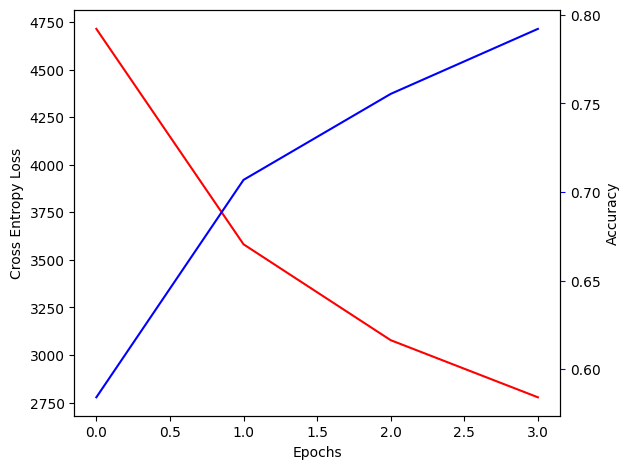

In [47]:
import matplotlib.pyplot as plt
def load_txt_to_list(filepath):
    with open(filepath, "r") as f:
        return [float(line.strip()) for line in f if line.strip()]

acc_epoch = load_txt_to_list("/kaggle/working/model_AG NEWS small1_acc.txt")
cum_loss_list = load_txt_to_list("/kaggle/working/model_AG NEWS small1_loss.txt")
plot(cum_loss_list,acc_epoch)

##  Selective Fine Tuning Model Pretrained on AG News Dataset on IMDB Dataset

In [48]:
model_fine1_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine1_.load_state_dict(torch.load('/kaggle/working/model_AG NEWS small1.pth'))


<All keys matched successfully>

In [49]:
import torch.nn as nn
model_fine1_.classifier=nn.Linear(50,2)

In [50]:
for params in model_fine1_.parameters():
    params.requires_grad=False

In [51]:
model_fine1_.classifier.out_features

2

In [52]:
model_fine1_

Net(
  (emb): Embedding(400000, 50)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=50, out_features=2, bias=True)
)

In [53]:
model_fine1_.classifier.in_features

50

In [54]:
for i in range(2):
    for params in model_fine1_.transformer_encoder.layers[i].linear2.parameters():
        params.requires_grad=True
model_fine1_.classifier=nn.Linear(50,2)


In [55]:
for name, param in model_fine1_.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

emb.weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_bias requires_grad: False
transformer_encoder.layers.0.self_attn.out_proj.weight requires_grad: False
transformer_encoder.layers.0.self_attn.out_proj.bias requires_grad: False
transformer_encoder.layers.0.linear1.weight requires_grad: False
transformer_encoder.layers.0.linear1.bias requires_grad: False
transformer_encoder.layers.0.linear2.weight requires_grad: True
transformer_encoder.layers.0.linear2.bias requires_grad: True
transformer_encoder.layers.0.norm1.weight requires_grad: False
transformer_encoder.layers.0.norm1.bias requires_grad: False
transformer_encoder.layers.0.norm2.weight requires_grad: False
transformer_encoder.layers.0.norm2.bias requires_grad: False
transformer_encoder.layers.1.self_attn.in_proj_weight requires_grad: False
transformer_encoder.layers.1.self_attn.in_proj_bias requires_grad: False
transformer_encoder.

In [56]:
import time 
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = "/kaggle/working"
file_name = "model_FineTuned_IMDB dataset small2.pth"
train_model(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_dataloader, 
            test_dataloader=test_dataloader, 
            epochs=100, 
            save_dir=save_dir, 
            file_name=file_name
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Loss: 805.8320600390434
0.6693
save model epoch 1
Epoch 2/100 - Loss: 761.7630177438259
0.6771
save model epoch 2
Epoch 3/100 - Loss: 730.8188031315804
0.7336
save model epoch 3
Epoch 4/100 - Loss: 708.2018023431301
0.7431
save model epoch 4
Epoch 5/100 - Loss: 690.7254458367825
0.7456
save model epoch 5
Epoch 6/100 - Loss: 675.2418912053108
0.7496
save model epoch 6
Epoch 7/100 - Loss: 661.7408296763897
0.7651
save model epoch 7
Epoch 8/100 - Loss: 653.5195634067059
0.775
save model epoch 8
Epoch 9/100 - Loss: 643.0913278013468
Epoch 10/100 - Loss: 626.9200017154217
0.7841
save model epoch 10
Epoch 11/100 - Loss: 623.6226647496223
Epoch 12/100 - Loss: 613.8499864935875
0.7846
save model epoch 12
Epoch 13/100 - Loss: 612.5643905103207
0.7954
save model epoch 13
Epoch 14/100 - Loss: 603.8214666694403
Epoch 15/100 - Loss: 599.4077695161104
0.8065
save model epoch 15
Epoch 16/100 - Loss: 590.6686954945326
Epoch 17/100 - Loss: 583.9555397629738
Epoch 18/100 - Loss: 580.576291

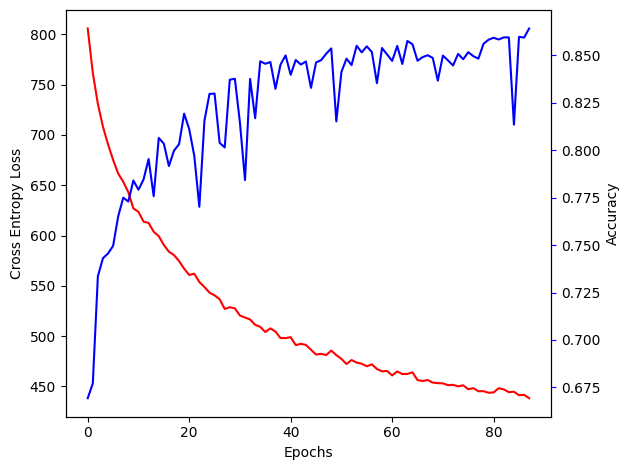

In [57]:
import matplotlib.pyplot as plt
def load_txt_to_list(filepath):
    with open(filepath, "r") as f:
        return [float(line.strip()) for line in f if line.strip()]

acc_epoch = load_txt_to_list("/kaggle/working/model_FineTuned_IMDB dataset small2_acc.txt")
cum_loss_list = load_txt_to_list("/kaggle/working/model_FineTuned_IMDB dataset small2_loss.txt")
plot(cum_loss_list,acc_epoch)

## Additive Fine-Tuning on pretrained Model on AG NEWS Dataset


### Making A Feature Adapter

In [58]:
class FeatureAdapter(nn.Module):
    def __init__(self,model_dim,bottleneck_size=50):
        super(FeatureAdapter,self).__init__()
        self.bottleneck=nn.Sequential(
            nn.Linear(model_dim,bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size,model_dim)
        )
    def forward(self,x):
        x=x+self.bottleneck(x)
        return x

### Making a Adapted Layer

In [59]:
class Adapted(nn.Module):
    def __init__(self,linear,bottleneck_size=50):
        super(Adapted,self).__init__()
        self.linear=linear
        model_dim=linear.out_features
        self.feature_adapter=FeatureAdapter(model_dim=model_dim,bottleneck_size=bottleneck_size)
    def forward(self,x):
        x=self.linear(x)
        x=self.feature_adapter(x)
        return x 

### Load The Save Pre-trained Model

In [60]:
model_adapted=Net(vocab_size=vocab_size,num_class=4)
model_adapted.load_state_dict(torch.load("/kaggle/working/model_AG NEWS small1.pth",map_location=device))

<All keys matched successfully>

### Updating the Model according to IMDB Dataset

In [61]:
in_features=model_adapted.classifier.in_features
model_adapted.classifier=nn.Linear(in_features,2)

### Freezing The Model's Parameters

In [62]:
for params in model_adapted.parameters():
    params.requires_grad=False

### Adding Adapter Layers to The Model

In [63]:
n_layer=model_adapted.transformer_encoder.layers

In [64]:
n_layer = len(model_adapted.transformer_encoder.layers)

for i in range(n_layer):
    transformer_encoder_layer = model_adapted.transformer_encoder.layers[i].linear1
    adapter = Adapted(transformer_encoder_layer)
    model_adapted.transformer_encoder.layers[i].linear1 = adapter
    transformer_encoder_layer2 = model_adapted.transformer_encoder.layers[i].linear2

### Fine-Tuning of The Model

In [65]:
model_adapted.to(device)

Net(
  (emb): Embedding(400000, 50)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Adapted(
          (linear): Linear(in_features=50, out_features=128, bias=True)
          (feature_adapter): FeatureAdapter(
            (bottleneck): Sequential(
              (0): Linear(in_features=128, out_features=50, bias=True)
              (1): ReLU()
              (2): Linear(in_features=50, out_features=128, bias=True)
            )
          )
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1

In [66]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_adapted.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = "/kaggle/working/"
file_name = "model_adapted.pth"
train_model(model=model_adapted, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,  epochs=80,  save_dir=save_dir ,file_name=file_name )

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/80 - Loss: 840.2042257785797
0.6772
save model epoch 1
Epoch 2/80 - Loss: 795.0362110733986
Epoch 3/80 - Loss: 775.4154241681099
0.7195
save model epoch 3
Epoch 4/80 - Loss: 764.838153719902
0.7274
save model epoch 4
Epoch 5/80 - Loss: 757.7433116137981
0.7284
save model epoch 5
Epoch 6/80 - Loss: 752.117330878973
0.7358
save model epoch 6
Epoch 7/80 - Loss: 748.6411173641682
0.7374
save model epoch 7
Epoch 8/80 - Loss: 743.4438923597336
Epoch 9/80 - Loss: 741.9853703975677
0.742
save model epoch 9
Epoch 10/80 - Loss: 739.5472053587437
0.7469
save model epoch 10
Epoch 11/80 - Loss: 736.7578484117985
0.7541
save model epoch 11
Epoch 12/80 - Loss: 735.2249862849712
Epoch 13/80 - Loss: 734.8507130742073
Epoch 14/80 - Loss: 733.0509939789772
0.7582
save model epoch 14
Epoch 15/80 - Loss: 731.8638199269772
0.7611
save model epoch 15
Epoch 16/80 - Loss: 730.3393948078156
Epoch 17/80 - Loss: 730.6216915845871
0.7627
save model epoch 17
Epoch 18/80 - Loss: 729.323328346014
Epoch 19/80 

In [ ]:
import matplotlib.pyplot as plt
def load_txt_to_list(filepath):
    with open(filepath, "r") as f:
        return [float(line.strip()) for line in f if line.strip()]

acc_epoch = load_txt_to_list("/kaggle/working/model_adapted_acc.txt")
cum_loss_list = load_txt_to_list("/kaggle/working/model_adapted_loss.txt")
plot(cum_loss_list,acc_epoch)